In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore



In [2]:
# Loading dataset

data_set=pd.read_excel("Healthcare_dataset.xlsx")

In [3]:
#check for missing values

missing_values=data_set.isnull().sum()

missing_columns=missing_values[missing_values > 0]
print(missing_columns)


Series([], dtype: int64)


From the result, it's clear that there is no missing values in the given dataset

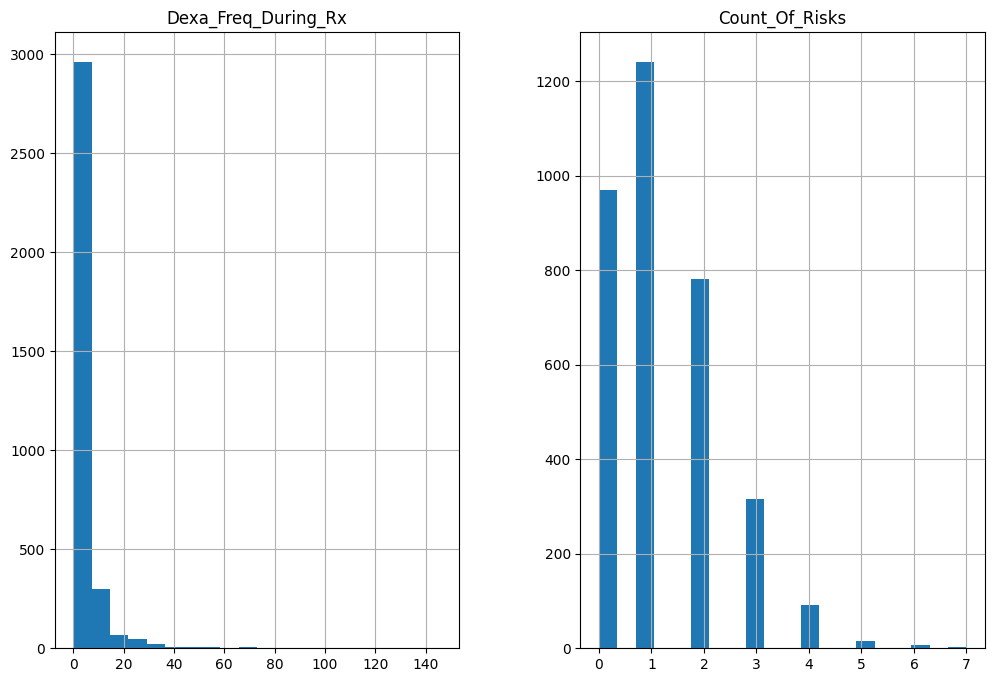

In [4]:
#Plot histograms to check the distribution of numerical features

data_set.hist(figsize=(12,8),bins=20)
plt.show()

The above distributions suggest that most patients have a low frequency of Dexa during Rx and tend to have 0-2 risks, with fewer patients having higher frequencies or more risks.

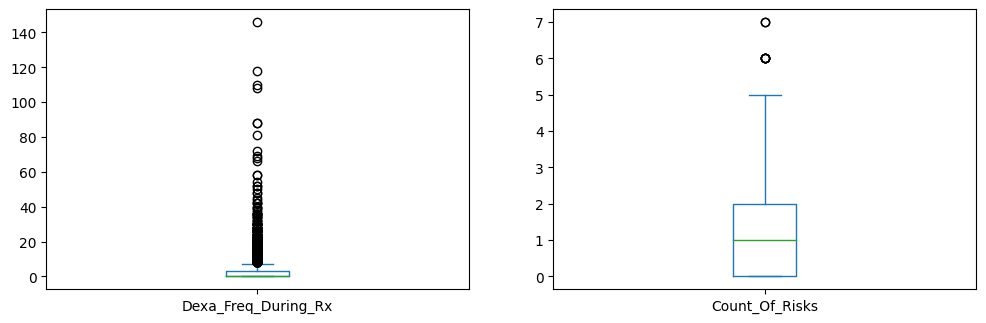

In [5]:
# plotting box plots to identify outliers

data_set.plot(kind='box', subplots=True,layout=(2,2),figsize=(12,8),sharex=False,sharey=False)
plt.show()

In Dexa_Freq_During_Rx, the box representing the interquartile range is very samll and close to 0. The median is very close to Zero. There is a long upper whisker extending to about 20. Many outliers are present, range from 20 to 140, with most extreme outlier at about 145. In COunt_Of_Risk, the box extends from 0 to 2, with the median at 1. The upper whisker extends to about 5, and a several outliers, with maximum at 7.

Both variables have outliers, but Dexa_Freq_During_Rx has more extreme outliers relative to its central tendency.

In [6]:
# handling outliers

# calculating Z-score for the numerical columns

data_set['Dexa_Freq_During_Rx_Z_Score']=zscore(data_set['Dexa_Freq_During_Rx'])
data_set['Count_Of_Risks_Z_Score']=zscore(data_set['Count_Of_Risks'])

# Setting threshold for finding outliers

threshold=3

# Filtering the outliers
data_cleaned=data_set[(abs(data_set['Dexa_Freq_During_Rx_Z_Score'])<threshold)&(abs(data_set['Count_Of_Risks_Z_Score'])<threshold)]


# dropping the Z-score column
data_cleaned=data_cleaned.drop(['Dexa_Freq_During_Rx_Z_Score','Count_Of_Risks_Z_Score'],axis=1)


# checking the shape of the cleaned dataset
data_cleaned.shape

(3344, 69)

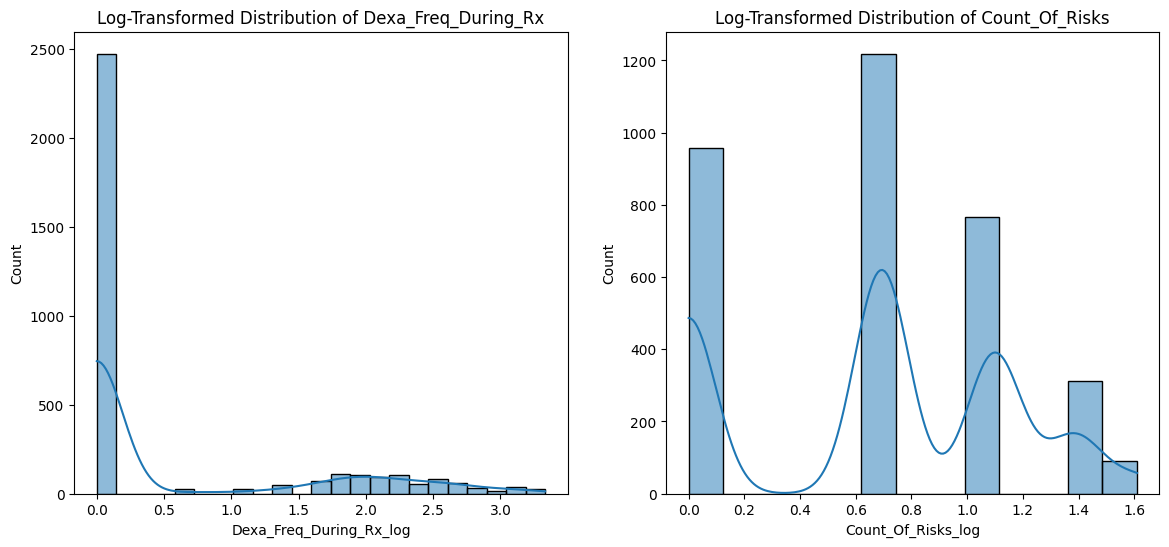

In [7]:
# Transforming skewed data

# From the above graph, it is clearly shows that Dexa_ is heavily right skewed
# and although Count_of_Risks is distributed evenly, it is lightly skewed.

# Applying log transformation to the numerical columns

data_cleaned['Dexa_Freq_During_Rx_log']=np.log1p(data_cleaned['Dexa_Freq_During_Rx'])
data_cleaned['Count_Of_Risks_log']=np.log1p(data_cleaned['Count_Of_Risks'])

# plotting the transformed data in histogram

plt.figure(figsize=(14,6))

# Histogram for Dexa_Freq_During_Rx_log
plt.subplot(1,2,1)
sns.histplot(data_cleaned['Dexa_Freq_During_Rx_log'],kde=True)
plt.title('Log-Transformed Distribution of Dexa_Freq_During_Rx')

# Histogram for COunt of Risks_log

plt.subplot(1,2,2)
sns.histplot(data_cleaned['Count_Of_Risks_log'],kde=True)
plt.title('Log-Transformed Distribution of Count_Of_Risks')

plt.show()

In [8]:
# Converting datatype of categorical columns to category datatype

categorical_columns=data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[categorical_columns]=data_cleaned[categorical_columns].astype('category')

# verifying the datatype
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3344 entries, 0 to 3423
Data columns (total 71 columns):
 #   Column                                                              Non-Null Count  Dtype   
---  ------                                                              --------------  -----   
 0   Ptid                                                                3344 non-null   category
 1   Persistency_Flag                                                    3344 non-null   category
 2   Gender                                                              3344 non-null   category
 3   Race                                                                3344 non-null   category
 4   Ethnicity                                                           3344 non-null   category
 5   Region                                                              3344 non-null   category
 6   Age_Bucket                                                          3344 non-null   category
 7   Ntm_Special

In [10]:
target_variable=data_cleaned['Persistency_Flag']
Feature_variable=data_cleaned.drop(['Persistency_Flag'],axis=1)

In [14]:
Feature_variable_cleaned=Feature_variable.drop(['Ptid'],axis=1)

In [20]:
# Function to apply one-hot encoding to categorical variables
def encoding(df):
    encoder = OneHotEncoder(sparse_output=False)
    data_encoded = encoder.fit_transform(df)
    encoded_df = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(df.columns))
    return encoded_df

In [21]:
# Apply one-hot encoding to feature variables
data_encoded = encoding(Feature_variable_cleaned)

In [22]:
data_encoded.shape

(3344, 245)

In [23]:
# Convert the target variable in category datatype to numerical datatype
target_variable_encoded = pd.Series(target_variable.cat.codes, name='Persistency_Flag')

In [24]:
# Combine the encoded feature variables and target variable into a single DataFrame
data_encoded_df = pd.DataFrame(data_encoded, columns=encoding(Feature_variable_cleaned).columns)
data_combined = pd.concat([data_encoded_df, target_variable_encoded], axis=1)

In [25]:
# Calculate the correlation matrix for the combined DataFrame
correlation_matrix = data_combined.corr()

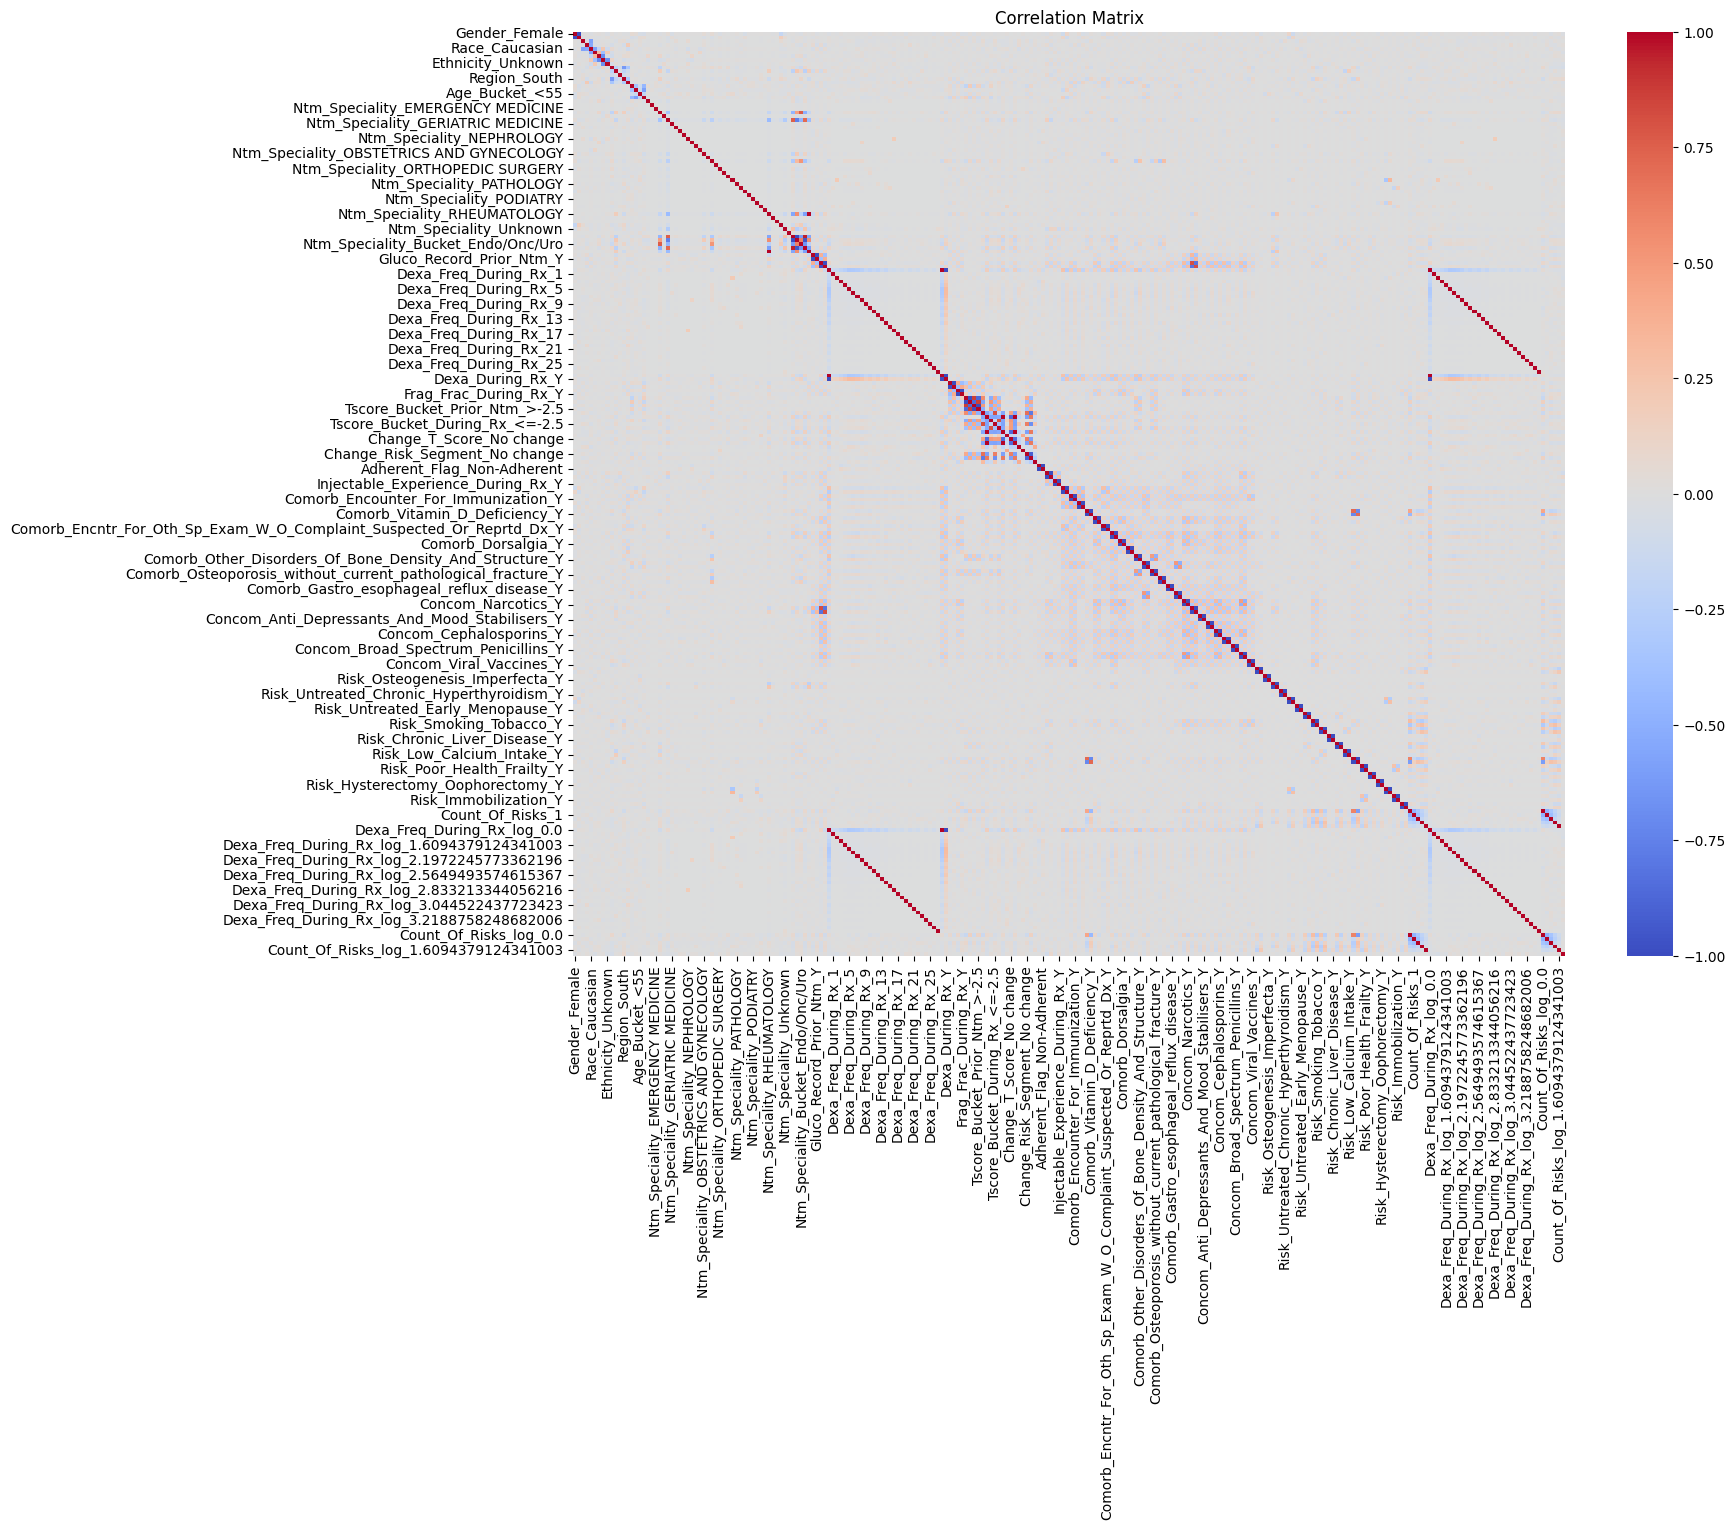

In [26]:
# Display the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [27]:
# Display the top 10 features most positively correlated with the target variable
target_correlation = correlation_matrix['Persistency_Flag'].sort_values(ascending=False)
top_positive_correlations = target_correlation.head(10)
print("Top 10 Positively Correlated Features:\n", top_positive_correlations)

Top 10 Positively Correlated Features:
 Persistency_Flag                                                     1.000000
Idn_Indicator_Y                                                      0.086721
Region_South                                                         0.078964
Ntm_Speciality_PULMONARY MEDICINE                                    0.052043
Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias_Y    0.050814
Injectable_Experience_During_Rx_Y                                    0.047119
Ntm_Speciality_OTOLARYNGOLOGY                                        0.043248
Risk_Family_History_Of_Osteoporosis_N                                0.041984
Dexa_Freq_During_Rx_19                                               0.039704
Dexa_Freq_During_Rx_log_2.995732273553991                            0.039704
Name: Persistency_Flag, dtype: float64


In [28]:
# Display the top 10 features most negatively correlated with the target variable
top_negative_correlations = target_correlation.tail(10)
print("Top 10 Negatively Correlated Features:\n", top_negative_correlations)

Top 10 Negatively Correlated Features:
 Tscore_Bucket_During_Rx_Unknown                                     -0.040374
Change_T_Score_Unknown                                              -0.040374
Risk_Family_History_Of_Osteoporosis_Y                               -0.041984
Ethnicity_Unknown                                                   -0.042371
Injectable_Experience_During_Rx_N                                   -0.047119
Dexa_Freq_During_Rx_log_1.0986122886681096                          -0.049152
Dexa_Freq_During_Rx_2                                               -0.049152
Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias_N   -0.050814
Region_Midwest                                                      -0.066896
Idn_Indicator_N                                                     -0.086721
Name: Persistency_Flag, dtype: float64
